In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from netCDF4 import num2date,date2num,Dataset
import matplotlib.gridspec as gridspec
import corner
%matplotlib inline

In [23]:
import pymc

In [52]:
import scipy

In [26]:
from marcus_py_tools import make_edge_vec

ModuleNotFoundError: No module named 'marcus_py_tools'

In [27]:
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def make_edge_vec(center_vec):s
    edge_vec = np.zeros(len(center_vec)+1)
    edge_vec[0] = center_vec[0] - .5*(center_vec[1]-center_vec[0])
    edge_vec[len(center_vec)] = center_vec[-1] + .5*(center_vec[-1]-center_vec[-2])
    for i in range(1,len(center_vec)):
        edge_vec[i] = .5*(center_vec[i]+center_vec[i-1])
    return edge_vec

In [46]:
cov_all  = np.array([[108.7,  105.16, 126.17],
                     [105.16, 131.2,  173.56],
                     [126.17, 173.56, 264.75]])
mean_all = np.array([35.34, 32.34, 37.80])
#mean_all_a = np.array([13.,   14.,   15.])
mean_all_a = mean_all*.5
#..
cov_dis  = np.array([[126.8,  180.82, 159.24],
                     [180.82, 286.7,  278.17],
                     [159.24, 278.17, 426.9 ]])
mean_dis = np.array([2.44, -4.34, 4.03])
#..
cov_bin  = np.array([[101.2,  96.55,  121.96],
                     [96.55,  121.1,  168.97],
                     [121.96, 168.97, 259.0 ]])
mean_bin = np.array([35.56, 32.34, 37.80])
#..

In [61]:
#..Consider the limits on M0,M3,M6 set by the bounds on ntop, qtop, ztop in the BOSS LHS Sampling
#..Convert from n,q,z to M0,M3,M6
qtop_min = 1.e-4
qtop_max = 5.e-3
ntop_min = 2.e2
ntop_max = 3.e4
mutop_min= 0.0
#mutop_max= 15.0
mutop_max= 2.0
#..Now sample from the uniform distribution (or do LHS)
qtop = pymc.Uniform(name='qtop', lower=qtop_min, upper=qtop_max)
ntop = pymc.Uniform(name='ntop', lower=ntop_min, upper=ntop_max)
mutop= pymc.Uniform(name='mutop',lower=mutop_min,upper=mutop_max)

mc     = pymc.MCMC([qtop,ntop,mutop])
mc.sample(10000)

#..Define ztop
lamr = (np.pi*1000.*mc.trace('ntop')[:]/mc.trace('qtop')[:])**(1./3.)
ztop = 10.*np.log10(1.e12*mc.trace('ntop')[:]*lamr*scipy.special.gamma(7+mc.trace('mutop')[:])/
                    (lamr**(7+mc.trace('mutop')[:])))

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sec

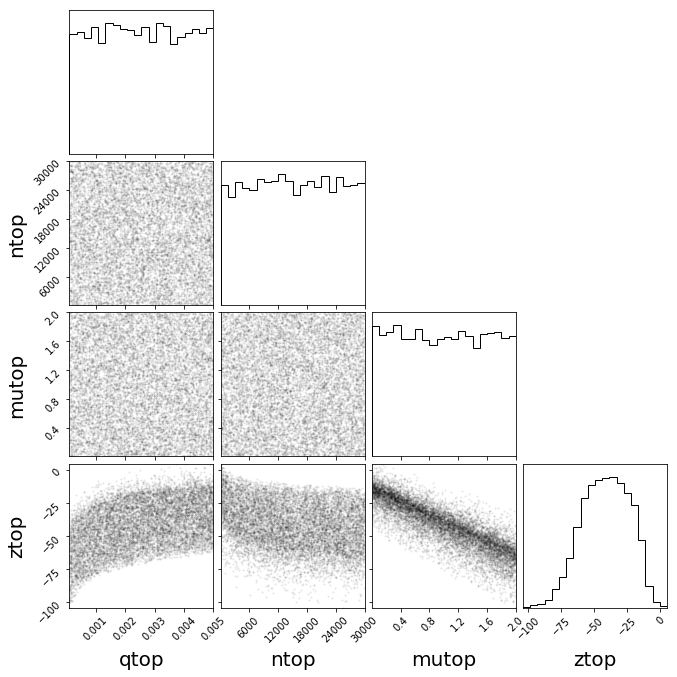

In [62]:
labs = ['qtop','ntop','mutop','ztop']
lab_kwargs = {'fontsize':'20'}
samples = np.vstack((mc.trace('qtop')[:],mc.trace('ntop')[:],mc.trace('mutop')[:],ztop))
fig,axes = corner.corner(samples.T,labels=labs, plot_density=False,plot_contours=False,
                         label_kwargs=lab_kwargs)

In [38]:
nc =  Dataset('/home/mvanlier/BOSS/BOSS_misc/M0_M3_all.nc','r')
h_M0_M3 = nc.variables['M0_M3'][:,:]
nc.close()
nc =  Dataset('/home/mvanlier/BOSS/BOSS_misc/M0_M6_all.nc','r')
h_M0_M6 = nc.variables['M0_M6'][:,:]
nc.close()
nc =  Dataset('/home/mvanlier/BOSS/BOSS_misc/M3_M6_all.nc','r')
h_M3_M6 = nc.variables['M3_M6'][:,:]
nc.close()
nc =  Dataset('/home/mvanlier/BOSS/BOSS_misc/MBINS_all.nc','r')
mbins = nc.variables['MBINS'][:]
nc.close()
#mbine = make_edge_vec(mbins)
mbine = np.r_[mbins,mbins[-1]+(mbins[-1]-mbins[-2])]
#.......
h_M0_M3 = np.ma.masked_where(h_M0_M3==0.,h_M0_M3)
h_M0_M6 = np.ma.masked_where(h_M0_M6==0.,h_M0_M6)
h_M3_M6 = np.ma.masked_where(h_M3_M6==0.,h_M3_M6)
#.......

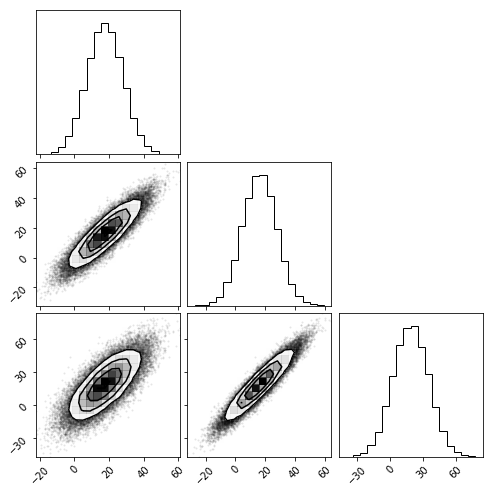

In [47]:
nsamp = 50000
#..
samples = np.random.multivariate_normal(mean_all_a,cov_all,nsamp)
#..
fig,axes = corner.corner(samples)
#..

In [31]:
samples.shape

(50000, 3)

In [ ]:
samp_qnz = np.zeros_like(samples)
samp_qnz[1]

In [48]:
h_M0M3_all,xe,ye = np.histogram2d(samples[:,0],samples[:,1],bins=mbine)
h_M0M6_all,xe,ye = np.histogram2d(samples[:,0],samples[:,2],bins=mbine)
h_M3M6_all,xe,ye = np.histogram2d(samples[:,1],samples[:,2],bins=mbine)
#..

/home/mvanlier/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/mvanlier/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/home/mvanlier/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


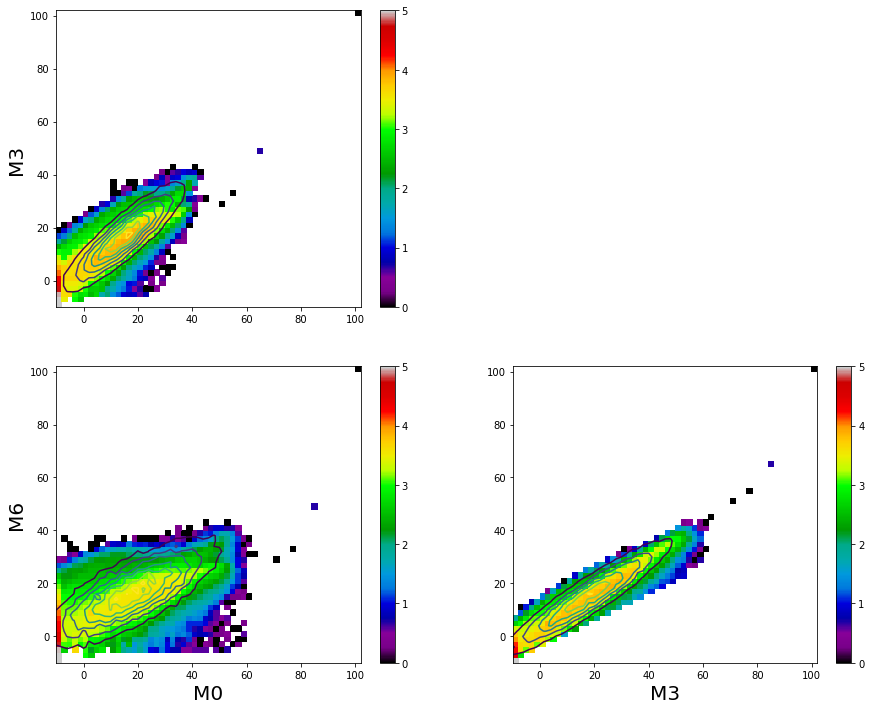

In [50]:
fig = plt.figure(figsize=(15,12))
ax=fig.add_subplot(221)
pc=plt.pcolormesh(mbine,mbine,np.log10(h_M0_M3.T),vmin=0,vmax=5,cmap=cm.nipy_spectral)
plt.contour(mbins,mbins,h_M0M3_all)
ax.set_ylabel('M3',fontsize=20)
plt.colorbar(pc)
ax=fig.add_subplot(223)
pc=plt.pcolormesh(mbine,mbine,np.log10(h_M0_M6.T),vmin=0,vmax=5,cmap=cm.nipy_spectral)
plt.contour(mbins,mbins,h_M0M6_all)
ax.set_xlabel('M0',fontsize=20)
ax.set_ylabel('M6',fontsize=20)
plt.colorbar(pc)
ax=fig.add_subplot(224)
pc=plt.pcolormesh(mbine,mbine,np.log10(h_M3_M6.T),vmin=0,vmax=5,cmap=cm.nipy_spectral)
plt.contour(mbins,mbins,h_M3M6_all)
ax.set_xlabel('M3',fontsize=20)
plt.colorbar(pc)

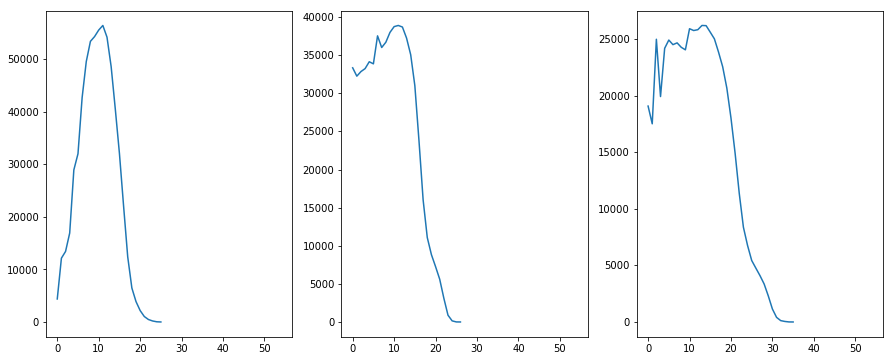

In [21]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(131)
plt.plot(h_M0_M3[1:,1:].sum(axis=0))
#....
ax = fig.add_subplot(132)
plt.plot(h_M0_M3[1:,1:].sum(axis=1))
#....
ax = fig.add_subplot(133)
plt.plot(h_M0_M6[1:,1:].sum(axis=1))
#....

In [45]:
np.savetxt('Kum_all_3gauss_00.txt', samples)